In [1]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
import albumentations as A
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
class MyDataset(Dataset):
    def __init__(self,
                 images_folder,
                 transform=None,
                 *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.images_folder = images_folder

        self.transform = transform if transform else \
            A.Compose(
                [
                    ToTensorV2(),
                ]
            )
        self.model_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

        self.images_paths = []
        self._read_images_names()

    def _read_images_names(self):
        for root, dirs, files in os.walk(self.images_folder):
            for image_name in files:
                img_path = os.path.join(root, image_name)

                _, ext = os.path.splitext(img_path)
                if ext not in ['.png', '.jpg', '.jpeg']:
                    continue

                self.images_paths.append(img_path)

    def __len__(self):
        return len(self.images_paths)
    
    def get_original_image(self, idx):
        filepath = self.images_paths[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return image.float()

    def __getitem__(self, idx):
        filepath = self.images_paths[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.transform(image=image)["image"]
        image = self.model_transform(image)

        return image.float()

In [3]:
my_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/faces_datasets/ds1")

In [4]:
len(my_dataset)

70000

In [17]:
class EmbeddingsExtractor(pl.LightningModule):

    def __init__(self):
        super(EmbeddingsExtractor, self).__init__()

        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
        )

        for name, param in self.model.named_parameters():
            # if "fc" in name or "layer4" in name or "layer3" in name:
            #     continue
            param.requires_grad = False

        # self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

    def get_embedings(self, dataset):
        dataloader = DataLoader(dataset, batch_size=16)
        self.eval()
        embeds = []
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(self.device)
                outputs = self(batch)
                embeds.append(outputs)
        return torch.cat(embeds)

In [18]:
my_dataset_1, my_dataset_2 = torch.utils.data.Subset(
    my_dataset, 
    range(
        len(my_dataset) // 2)
    ), \
    torch.utils.data.Subset(
        my_dataset, 
        range(len(my_dataset) // 2, 
        len(my_dataset))
    )

In [19]:
import torch.utils
import torch.utils.data


def get_embeds_example(dataset, extractor, subsample_size=1_000, random_seed=42):
    np.random.seed(random_seed)
    idxs = np.random.choice(range(len(dataset)), subsample_size, replace=True)
    subset = torch.utils.data.Subset(dataset, idxs)
    
    embeds = extractor.get_embedings(subset)
    return embeds

In [20]:
extractor = EmbeddingsExtractor()

In [21]:
get_embeds_example(my_dataset, extractor, 10).shape

torch.Size([10, 512])

In [22]:
embeds1, embeds2 = get_embeds_example(my_dataset_1, extractor, random_seed=42), get_embeds_example(my_dataset_2, extractor, random_seed=69)

In [23]:
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error as mse
from itertools import product

def _mean_similarity(emb1, emb2):

    sim_sum = 0
    for el1 in emb1:
        for el2 in emb2:
            sim_sum += np.dot(el1, el2) / (np.linalg.norm(el1) * np.linalg.norm(el2))
    
    return sim_sum / len(emb1) / len(emb2)


def embeds_list_similarity(emb1, emb2):
    emb1, emb2 = np.array(emb1), np.array(emb2)

    return np.mean(_mean_similarity(emb1, emb2))

In [24]:
embeds_list_similarity(embeds1, embeds2)

0.7295442850151658

In [27]:
def get_similarities(ds1, ds2, subsample_size=100, iters=100):
    similarities_list = []
    for seed in tqdm(range(iters)):
        embeds1, embeds2 = get_embeds_example(
            ds1, extractor, random_seed=seed, subsample_size=subsample_size), get_embeds_example(
                ds2, extractor, random_seed=seed**2, subsample_size=subsample_size)
        similarities_list.append(embeds_list_similarity(embeds1, embeds2))
    return similarities_list

In [29]:
similarities_list = get_similarities(my_dataset_1, my_dataset_2)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 3.,  3.,  1.,  8.,  4.,  7., 11.,  9., 12., 11.,  7.,  2.,  5.,
         6.,  2.,  4.,  1.,  1.,  2.,  1.]),
 array([0.72106318, 0.7223196 , 0.72357602, 0.72483244, 0.72608886,
        0.72734528, 0.7286017 , 0.72985812, 0.73111454, 0.73237096,
        0.73362738, 0.7348838 , 0.73614022, 0.73739664, 0.73865306,
        0.73990948, 0.7411659 , 0.74242232, 0.74367874, 0.74493516,
        0.74619158]),
 <BarContainer object of 20 artists>)

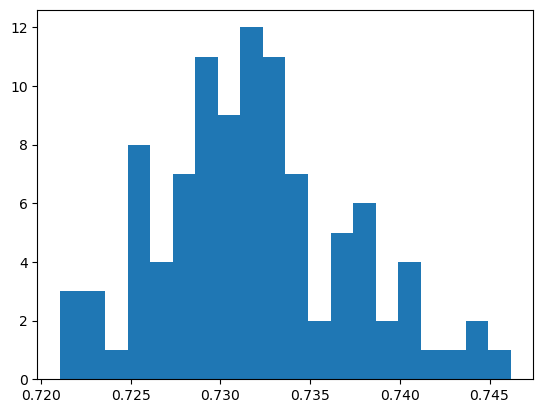

In [30]:
plt.hist(similarities_list, bins=20)

In [31]:
test_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/faces_datasets/ds2")
len(test_dataset), len(my_dataset)

(12000, 70000)

In [32]:
similarities_test_list_1 = get_similarities(my_dataset_1, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 2.,  2.,  2.,  0.,  5.,  5., 12., 11.,  6.,  9.,  4.,  6., 11.,
         6.,  5.,  4.,  8.,  0.,  0.,  2.]),
 array([0.67692125, 0.67826136, 0.67960146, 0.68094156, 0.68228166,
        0.68362176, 0.68496186, 0.68630196, 0.68764206, 0.68898217,
        0.69032227, 0.69166237, 0.69300247, 0.69434257, 0.69568267,
        0.69702277, 0.69836287, 0.69970297, 0.70104308, 0.70238318,
        0.70372328]),
 <BarContainer object of 20 artists>)

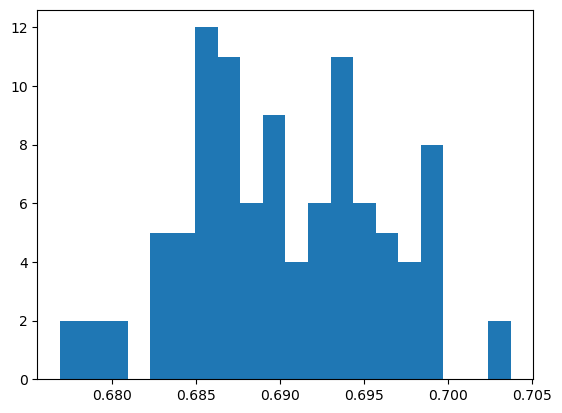

In [33]:
plt.hist(similarities_test_list_1, bins=20)

In [36]:
similarities_test_list_2 = get_similarities(my_dataset_2, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 2.,  2.,  3.,  4.,  4., 11.,  6., 11., 16.,  4., 11.,  4.,  5.,
         5.,  2.,  3.,  3.,  1.,  1.,  2.]),
 array([0.67727247, 0.67862432, 0.67997618, 0.68132804, 0.6826799 ,
        0.68403175, 0.68538361, 0.68673547, 0.68808732, 0.68943918,
        0.69079104, 0.6921429 , 0.69349475, 0.69484661, 0.69619847,
        0.69755033, 0.69890218, 0.70025404, 0.7016059 , 0.70295775,
        0.70430961]),
 <BarContainer object of 20 artists>)

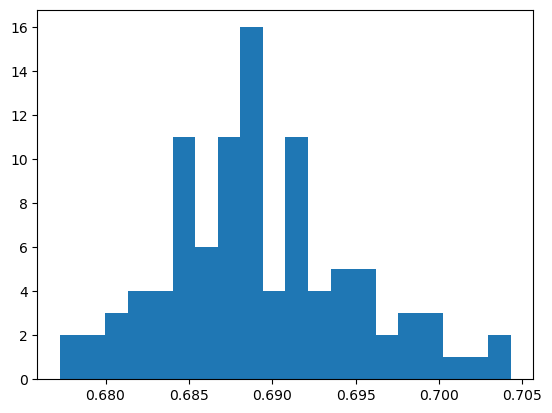

In [37]:
plt.hist(similarities_test_list_2, bins=20)

In [ ]:
def plot_images(dataset, cnt, random_state=42):
    idxs = np.random.choice(range(len(dataset)), cnt, replace=False)
    subset = torch.utils.data.Subset(dataset, idxs)

    rows = int(np.ceil(cnt ** 0.5))
    cols = int(cnt ** 0.5)
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

    for i in range(len(subset)):
        axs[i // cols, i % cols].imshow(subset[i])

    plt.show()

In [35]:
np.ceil(1.2)

2.0